In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
RAND_SEED=1

## 相位噪声模拟  
时间分辨率1us，采样率1MHz，模拟时间1s  
用布朗运动模拟相位噪声

      phase speed     phase
Mean    -0.000002 -6.359112
Std      0.008713  2.486367
Var      0.000076  6.182020


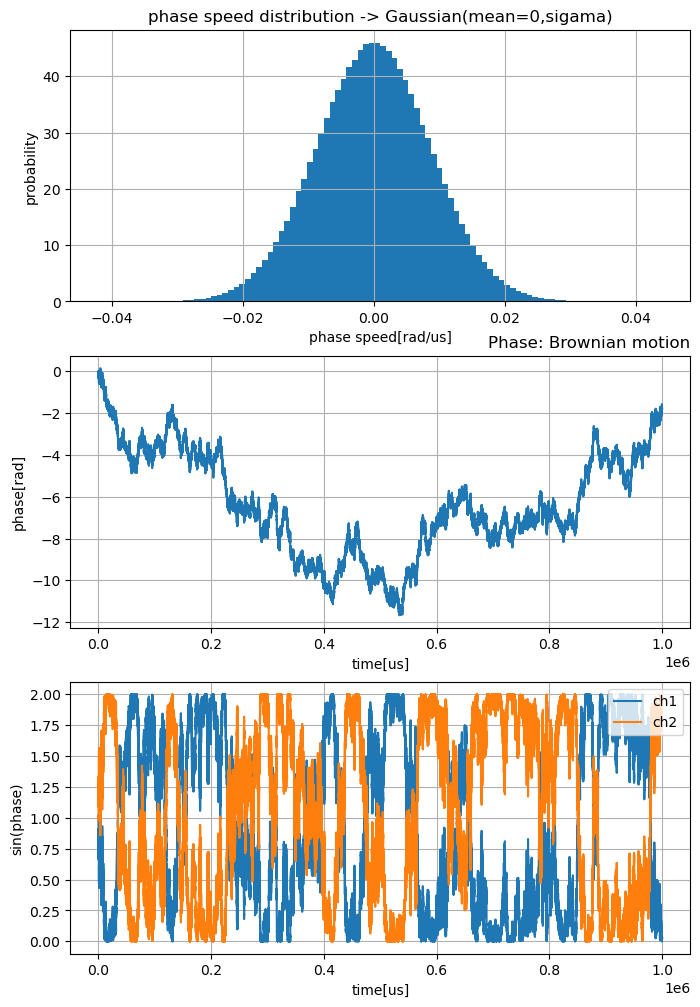

In [2]:
GAMMY=1.0

def get_sig_from_speed(phase_speed,channel):
    phase=np.cumsum(phase_speed)
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))
def get_sig_from_phase(phase,channel):
    #phase*=np.pi/180
    if channel==1:
        return SIG_AMP*(GAMMY+np.sin(phase))
    elif channel==2:
        return SIG_AMP*(GAMMY-np.sin(phase))

PHASE_SEEPD=0.5/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
time_axis=np.arange(0,1e6,1) #1us分辨率，len=1s  SR=1M
rng=np.random.default_rng(RAND_SEED)
phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
phase_speed[0]=0
phase=np.cumsum(phase_speed)
sig_ch1=get_sig_from_speed(phase_speed,1)
sig_ch2=get_sig_from_speed(phase_speed,2)
plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.hist(phase_speed,bins=100,density=True)
plt.ylabel('probability')
plt.xlabel('phase speed[rad/us]')
plt.title('phase speed distribution -> Gaussian(mean=0,sigama)')
plt.grid()
plt.subplot(3,1,2)
plt.plot(time_axis,phase)
plt.xlabel('time[us]')
plt.ylabel('phase[rad]')
plt.title('Phase: Brownian motion',loc='right')
plt.grid()
plt.subplot(3,1,3)
plt.plot(time_axis,sig_ch1,label='ch1')
plt.plot(time_axis,sig_ch2,label='ch2')
plt.xlabel('time[us]')
plt.ylabel('sin(phase)')
plt.grid()
plt.legend(loc=1)
#plt.xlim(0,100000)

df=pd.DataFrame({'Mean':phase_speed.mean(),'Std':phase_speed.std(),'Var':phase_speed.var()},index=['phase speed']).T
def push_data(data,name):
    df[name]=[data.mean(),data.std(),data.var()]
    print(df)
push_data(phase,'phase')

如果相位噪声满足独立随机分布，那么用var评估比较好，因为其关于时间（采样点）是线性的；

### method 1: 反馈1个sample  
每隔 time exposure 反馈一次  

In [3]:
def get_phase_from_count(ch1,ch2):
    if ch1+ch2==0:
        return 0
    else:
        return np.arcsin((ch1-ch2)/(ch1+ch2))

def measure_count(sig,method):
    """method=0:测量返回测量时间内最后一个时刻的phase;  
    method=1:测量时间内的phase的积分;  
    method=2:测量时间内的phase的积分，并引入shot noise;"""
    if method==0:
        return sig[-1]
    elif method==1:
        return sig.sum()
    elif method==2:
        return rng.poisson(sig.sum())
    

time_exposure=100 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M1=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M1=np.zeros_like(phase_speed_M1)
phase_measure_M1=np.zeros(phase_speed_M1.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M1[i]=np.cumsum(phase_speed_M1[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M1[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M1[i],2)
    ###引入shot noise
    ch1_measure=measure_count(sig_ch1_exposure[i],2)#rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
    ch2_measure=measure_count(sig_ch2_exposure[i],2)#rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
    phase_measure_M1[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #phase_measure_M1[i]=phase_M1[i,-1]
    
    ##---反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M1[i+1,0]-=phase_measure_M1[i]#fb_weight(phase_measure_M1[i],time_exposure) # 反馈到下一个exposure

    phase_offest=phase_M1[i,-1]
phase_out_M1=np.cumsum(phase_speed_M1.reshape(-1))
push_data(phase_out_M1,'phase M1')

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 54212.81it/s]

      phase speed     phase  phase M1
Mean    -0.000002 -6.359112 -0.000130
Std      0.008713  2.486367  0.106453
Var      0.000076  6.182020  0.011332


(0.0, 1000.0)

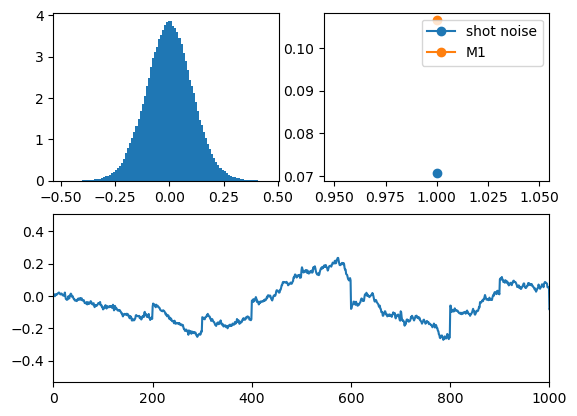

In [14]:
# 分别画出不同方法的相位和相位速度的分布
plt.figure()
ax1=plt.subplot(2,2,1)
ax1.hist(phase_out_M1,bins=100,density=True,label='M1')
ax2=plt.subplot(2,2,2)
ax2.plot(SIG_AMP,1/np.sqrt(SIG_AMP*time_exposure*2),'o-',label='shot noise')
ax2.plot(SIG_AMP,np.std(phase_out_M1),'o-',label='M1')
ax2.legend(loc=1)
ax3=plt.subplot(2,1,2)
ax3.plot(time_axis,phase_out_M1,label='M1')
ax3.set_xlim(0,1000)


### Method 2：反馈平均到sample

In [5]:
def fb_weight(measure, time_exposure):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=3*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered

time_exposure=20 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M2=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M2=np.zeros_like(phase_speed_M2)
phase_measure_M2=np.zeros(phase_speed_M2.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M2[i]=np.cumsum(phase_speed_M2[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M2[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M2[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    phase_measure_M2[i]=get_phase_from_count(ch1_measure,ch2_measure) 
    c0=get_phase_from_count(ch1_measure,ch2_measure)
    #c0=get_phase_from_count(sig_ch1_exposure[i].sum(),sig_ch2_exposure[i].sum())   # 最优估计
    phase_fb_M2=np.sign(phase_measure_M2[i])*np.abs(c0)
    
    ##-- 反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        #phase_speed_M2[i+1,0]-=fb_weight(phase_measure_M2[i],time_exposure=time_exposure)
        phase_speed_M2[i+1]-=phase_fb_M2/time_exposure # 反馈到下一个exposure

    phase_offest=phase_M2[i,-1]
phase_out_M2=np.cumsum(phase_speed_M2.reshape(-1))
push_data(phase_out_M2,'phase M2')

100%|██████████| 50000/50000 [00:04<00:00, 12351.56it/s]


      phase speed     phase  phase M1  phase M2
Mean    -0.000002 -6.359112  0.001449 -0.000043
Std      0.008713  2.486367  0.165383  0.176972
Var      0.000076  6.182020  0.027352  0.031319


### Method 3: M2迭代版本

In [6]:
time_exposure=20 #us
time_iter1=5 # iter*time_exposure
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M3=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M3=np.zeros_like(phase_speed_M3)
phase_measure_M3=np.zeros(phase_speed_M3.shape[0]) # 测量出的反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M3[i]=np.cumsum(phase_speed_M3[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M3[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M3[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    phase_measure_M3[i]=get_phase_from_count(ch1_measure,ch2_measure) 
    c0=get_phase_from_count(ch1_measure,ch2_measure)
    phase_fb_M3=np.sign(phase_measure_M3[i])*np.abs(c0)
    
    ##-- 反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M3[i+1]-=phase_fb_M3/time_exposure # 反馈到下一个exposure
    
    ##-- 迭代反馈 one 10*time_exposure
    
    if i%time_iter1==0 and i!=0:
        ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum())
        phase_measure_M3_it1=get_phase_from_count(ch1_measure,ch2_measure)
        c0=get_phase_from_count(ch1_measure,ch2_measure)#/100
        phase_fb_M3=np.sign(phase_measure_M3_it1)*np.abs(c0)
        phase_speed_M3[i+1:i+time_iter1+1]-=phase_fb_M3/time_exposure/time_iter1

    phase_offest=phase_M3[i,-1]
phase_out_M3=np.cumsum(phase_speed_M3.reshape(-1))
push_data(phase_out_M3,'phase M3')

100%|██████████| 50000/50000 [00:03<00:00, 12569.21it/s]

      phase speed     phase  phase M1  phase M2  phase M3
Mean    -0.000002 -6.359112  0.001449 -0.000043  0.000152
Std      0.008713  2.486367  0.165383  0.176972  0.177265
Var      0.000076  6.182020  0.027352  0.031319  0.031423


### Method 4：权重反馈

由于相位漂移速度是满足整体分布的随机变量，意味着其不具有时间相关性，每个时刻的相位速度独立同分布。因此，我们可以使用加权平均的方法来计算反馈量。具体来说，我们可以将每个时刻的相位速度乘以一个权重，然后将这些加权相位速度相加，得到最终的反馈量。这样，我们可以确保反馈量能够反映相位速度的整体分布，从而提高反馈的准确性。  
反馈的权重存在最佳估计，即反馈时间内的相位漂移量。但实际情况中往往很难估计出准确的相位漂移量，主要原因主要有两点：  
1. 测量引入的测量噪声，其中散粒噪声（shot noise）占主要成分。散粒噪声中的随机性来源于光子计数，其统计特性为泊松分布，且与信号强度成正比。因此，测量噪声的大小与信号强度成正比，信号强度越强，测量噪声越大。  
2. 测量存在测量时间，并非瞬时进行的。因此测量并不能够捕捉到相位漂移的瞬时变化，测量结果往往与实际相位漂移存在一定的偏差。  
为了解决这个问题，我们可以使用加权平均的方法来计算反馈量。具体来说，我们可以将每个时刻的相位速度乘以一个权重，然后将这些加权相位速度相加，得到最终的反馈量。这样，我们可以确保反馈量能够反映相位速度的整体分布，从而提高反馈的准确性。  
相位变化是一个维纳过程，其变化率服从高斯分布，一定时间内的相位变化服从高斯分布。我们可以考虑对于在一定置信区间内的相位变化进行全量反馈，对于超出置信区间的相位变化进行部分反馈。对于一般的高斯分布，其在3σ之外的值出现的概率为0.27%，因此我们可以将3σ之外的相位变化视为异常，进行部分反馈。

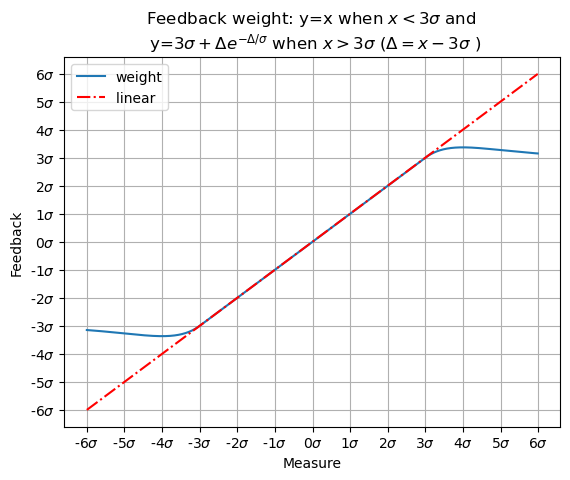

In [4]:
def fb_weight(measure, time_exposure,sigma=3):
    phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
    threshold=sigma*phase_speed_in_measure #3 sigma
    weight=lambda x: np.sign(x) *(threshold + (np.abs(x) - threshold)*np.exp(- (np.abs(x) - threshold)/phase_speed_in_measure))
    mask = np.abs(measure) > threshold
    measure_filtered = np.where(mask, weight(measure),measure)
    return measure_filtered

phase_speed_in_measure=np.sqrt(time_exposure)*PHASE_SEEPD #sigma
x=np.arange(-2,2,1/256)*3*phase_speed_in_measure
plt.plot(x,fb_weight(x,time_exposure=time_exposure),label='weight')
plt.plot(x,x,'r-.',label='linear ')
plt.legend()
plt.grid()
plt.xticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.yticks(np.arange(-6,7,1)*1*phase_speed_in_measure,['{}$\sigma$'.format(i*1) for i in np.arange(-6,7,1)])
plt.xlabel('Measure')
plt.ylabel('Feedback')
plt.title('Feedback weight: y=x when $x<3\sigma$ and \n y=3$\sigma+\Delta e^{-\Delta/\sigma}$ when $x>3\sigma$ ($\Delta =x-3\sigma$ )')
plt.show()

In [22]:
time_exposure=2 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M4=np.zeros_like(phase_speed_M4)
phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量
phase_fb_M4=np.zeros(phase_speed_M4.shape[0]) # 反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
fb0=0
sigma=1
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #c0=get_phase_from_count(sig_ch1_exposure[i,-1],sig_ch2_exposure[i,-1])
    c0=phase_measure_M4[i]
    
    phase_fb_M4[i]=fb_weight(c0,time_exposure=time_exposure,sigma=1.2)


    ##-- 反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M4[i+1,0]-=phase_fb_M4[i]#/time_exposure # 反馈到下一个exposure

    phase_offest=phase_M4[i,-1]
phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
push_data(phase_out_M4,'phase M4')

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [00:13<00:00, 36357.15it/s]

      phase speed     phase  phase M1  phase M4
Mean    -0.000002 -6.359112 -0.000130 -0.000652
Std      0.008713  2.486367  0.106453  0.084525
Var      0.000076  6.182020  0.011332  0.007145


In [39]:
time_exposure=2 #us
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M4=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M4=np.zeros_like(phase_speed_M4)
phase_measure_M4=np.zeros(phase_speed_M4.shape[0]) # 测量量
phase_fb_M4=np.zeros(phase_speed_M4.shape[0]) # 反馈量
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
fb0=0
sigma=1
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M4[i]=np.cumsum(phase_speed_M4[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M4[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M4[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    phase_measure_M4[i]=get_phase_from_count(ch1_measure,ch2_measure)
    #c0=get_phase_from_count(sig_ch1_exposure[i,-1],sig_ch2_exposure[i,-1])
    c0=phase_measure_M4[i]
    
    if fb0*c0 <0:
        sigma=1.2
        phase_fb_M4[i]=fb_weight(c0,time_exposure=time_exposure,sigma=sigma)
    else:
        sigma=1.2+(2-sigma)/2
        phase_fb_M4[i]=fb_weight(c0,time_exposure=time_exposure,sigma=sigma)
    fb0=c0

    ##-- 反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M4[i+1,0]-=phase_fb_M4[i]#/time_exposure # 反馈到下一个exposure

    phase_offest=phase_M4[i,-1]
phase_out_M4=np.cumsum(phase_speed_M4.reshape(-1))
push_data(phase_out_M4,'phase M4')

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [00:14<00:00, 35493.06it/s]

      phase speed     phase  phase M1  phase M4
Mean    -0.000002 -6.359112 -0.000130  0.000372
Std      0.008713  2.486367  0.106453  0.086104
Var      0.000076  6.182020  0.011332  0.007414


In [36]:
fb_dirc=(np.sign(phase_measure_M4*phase_M4[:,-1].reshape(-1)))
print('反馈方向错误:{:.2%}'.format(fb_dirc[fb_dirc<0].size/fb_dirc.size))
print('反馈方向正确:{:.2%}'.format(fb_dirc[fb_dirc>0].size/fb_dirc.size))

反馈方向错误:34.48%
反馈方向正确:45.12%


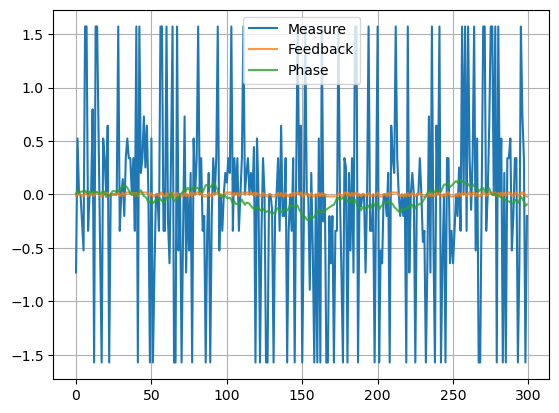

In [38]:
x0=200
x1=500
plt.plot(phase_measure_M4[x0:x1],label='Measure')
plt.plot(phase_fb_M4[x0:x1],alpha=0.8,label='Feedback')
plt.plot(phase_M4[:,-1].reshape(-1)[x0:x1],alpha=0.8,label='Phase')
plt.legend()
plt.grid()
plt.show()

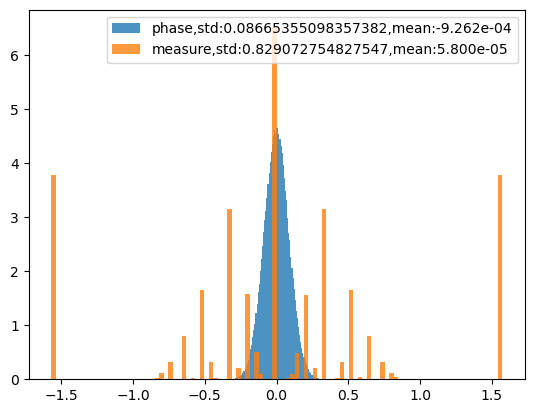

In [31]:
plt.hist(phase_out_M4[time_exposure-1::time_exposure],bins=100,density=True,alpha=0.8,label='phase,std:{},mean:{:.3e}'.format(phase_out_M4.std(),phase_out_M4.mean()))
plt.hist(phase_measure_M4,bins=100,density=True,alpha=0.8,label='measure,std:{},mean:{:.3e}'.format(phase_measure_M4.std(),phase_measure_M4.mean()))
plt.legend()

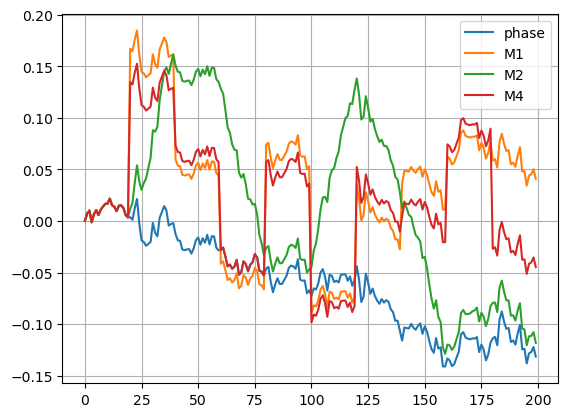

In [16]:
x0=0000
x1=200
plt.plot(phase[x0:x1],label='phase')
plt.plot(phase_out_M1[x0:x1],label='M1')
plt.plot(phase_out_M2[x0:x1],label='M2')
plt.plot(phase_out_M4[x0:x1],label='M4')
#plt.xlim(10000,20000)
plt.legend(loc=1)
plt.grid()

### Method 5：并行反馈

In [1]:
time_exposure=2 #us
time_iter1=2 # iter*time_exposure 
time_iter2=3 # iter*time_exposure
time_iter3=0
time_iter4=0
print('time exposure:',time_exposure,'iter:',time_iter1*time_exposure,time_iter2*time_exposure,time_iter3*time_exposure,time_iter4*time_exposure,'us')
sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
phase_speed_M5=np.copy(phase_speed.reshape((-1,time_exposure)))
phase_M5=np.zeros_like(phase_speed_M5)
phase_measure_M5=np.zeros(phase_speed_M5.shape[0]) # 测量出的反馈量
phase_measure_it1_M5=np.zeros(phase_speed_M5.shape[0])
phase_measure_it2_M5=np.zeros(phase_speed_M5.shape[0])
phase_measure_it3_M5=np.zeros(phase_speed_M5.shape[0])
phase_measure_it4_M5=np.zeros(phase_speed_M5.shape[0])
rng=np.random.default_rng(RAND_SEED)
phase_offest=0
for i in tqdm(range(sig_ch1_exposure.shape[0])):
    phase_M5[i]=np.cumsum(phase_speed_M5[i])+phase_offest
    sig_ch1_exposure[i]=get_sig_from_phase(phase_M5[i],1)
    sig_ch2_exposure[i]=get_sig_from_phase(phase_M5[i],2)
    ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
    ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
    phase_measure_M5[i]=get_phase_from_count(ch1_measure,ch2_measure) 
    c0=fb_weight(phase_measure_M5[i],time_exposure=time_exposure)
    phase_fb_M5=c0
    
    ##-- 反馈
    if i<(sig_ch1_exposure.shape[0]-1):
        phase_speed_M5[i+1,0]-=phase_fb_M5#/time_exposure # 反馈到下一个exposure
    
    ##-- 迭代反馈 one 10*time_exposure
    
    if i%time_iter1==0 and i!=0:
        phaseit1=phase_M5[i,-1]+phase_speed_M5[i+1,0]
        suffix1=get_sig_from_phase(phaseit1,1)
        suffix2=get_sig_from_phase(phaseit1,2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
        ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
        phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
        phase_measure_it1_M5[i]=phase_measure_M5_it1
        c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1)
        phase_speed_M5[i+1,1]-=c0
    
    if i%time_iter2==0 and i!=0:
        phaseit2=phase_M5[i,-1]+phase_speed_M5[i+1,:2].sum()
        suffix1=get_sig_from_phase(phaseit2,1)
        suffix2=get_sig_from_phase(phaseit2,2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter2:i+1].sum()+suffix1)
        ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter2:i+1].sum()+suffix2)
        phase_measure_M5_it2=get_phase_from_count(ch1_measure,ch2_measure)
        c0=fb_weight(phase_measure_M5_it2,time_exposure=time_exposure*time_iter2)
        phase_speed_M5[i+2,1]-=c0
    
    if i%time_iter3==0 and i!=0:
        ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter3:i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter3:i].sum())
        phase_measure_M5_it3=get_phase_from_count(ch1_measure,ch2_measure)
        c0=fb_weight(phase_measure_M5_it3,time_exposure=time_exposure*time_iter3)
        phase_speed_M5[i:i+time_iter3,0]-=c0/time_exposure#/time_iter3

    # if i%time_iter4==0 and i!=0:
    #     ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter4:i].sum())
    #     ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter4:i].sum())
    #     phase_measure_M5_it4=get_phase_from_count(ch1_measure,ch2_measure)
    #     c0=fb_weight(phase_measure_M5_it4,time_exposure=time_exposure*time_iter4)
    #     phase_speed_M5[i:i+time_iter4,0]-=c0/time_exposure#/time_iter4
    
    phase_offest=phase_M5[i,-1]
phase_out_M5=np.cumsum(phase_speed_M5.reshape(-1))
push_data(phase_out_M5,'phase M5')

time exposure: 2 iter: 4 6 0 0 us


NameError: name 'sig_ch1' is not defined

In [36]:
phase_out_M4=simu_phase(phase_speed,time_exposure,method=4)
push_data(phase_out_M4,'phase M4')

100%|██████████| 500000/500000 [00:45<00:00, 10979.84it/s]


      phase speed     phase  phase M1  phase M2  phase M3  phase M4  phase M5
Mean    -0.000002 -6.359112  0.001449 -0.000043  0.000152 -0.000502  0.000545
Std      0.008713  2.486367  0.165383  0.176972  0.177265  0.105554  0.096527
Var      0.000076  6.182020  0.027352  0.031319  0.031423  0.011142  0.009317


In [50]:
phase_out_M4=simu_phase(phase_speed,time_exposure*time_iter1,method=4)
push_data(phase_out_M4,'phase M4')

100%|██████████| 250000/250000 [00:15<00:00, 16383.52it/s]

      phase speed     phase  phase M1  phase M2  phase M3  phase M4  phase M5
Mean    -0.000002 -6.359112  0.001449 -0.000043  0.000152 -0.000105  0.000545
Std      0.008713  2.486367  0.165383  0.176972  0.177265  0.110837  0.096527
Var      0.000076  6.182020  0.027352  0.031319  0.031423  0.012285  0.009317


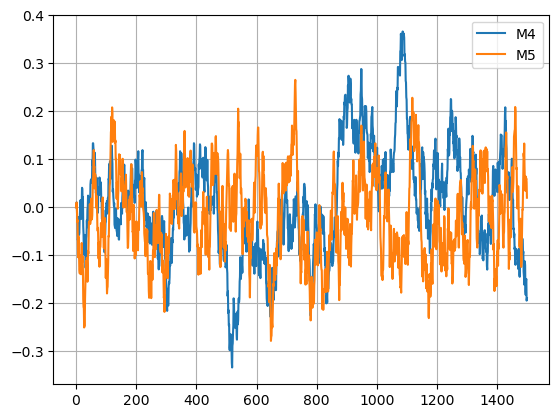

In [49]:
x0=000
x1=1500
#plt.plot(phase[x0:x1],label='phase')
#plt.plot(phase_out_M1[x0:x1],label='M1')
# plt.plot(phase_out_M2[x0:x1],label='M2')
plt.plot(phase_out_M4[x0:x1],label='M4')
plt.plot(phase_out_M5[x0:x1],label='M5')
#plt.plot(time_axis[x0:x1][time_exposure-1::time_exposure],phase_measure_M5[x0:x1//time_exposure],'.-',label='M5_measure')
#plt.plot(time_axis[x0:x1][time_exposure-1::time_exposure],phase_measure_it1_M5[x0:x1//time_exposure],'.-',label='M5_measure_it1')
#plt.plot(time_axis[x0:x1][::time_exposure],phase_measure_M5_it2[x0:x1//time_exposure],'-',label='M5_measure_it2')
plt.legend(loc=1)
plt.grid()

In [62]:
def simu_phase_M5_iter2(phase_speed,sigma0=1.2,sigma1=1.2,sigma2=1.2,RAND_SEED=RAND_SEED):
    time_exposure=2 #us
    time_iter1=2 # iter*time_exposure 
    time_iter2=49 # iter*time_exposure
    #print('time exposure:',time_exposure,'iter:',time_iter1*time_exposure,time_iter2*time_exposure,time_iter3*time_exposure,time_iter4*time_exposure,'us')
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M5=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M5=np.zeros_like(phase_speed_M5)
    phase_measure_M5=np.zeros(phase_speed_M5.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M5.shape[0])
    phase_measure_it2_M5=np.zeros(phase_speed_M5.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    it3_fb_list=[]
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M5[i]=np.cumsum(phase_speed_M5[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M5[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M5[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        phase_measure_M5[i]=get_phase_from_count(ch1_measure,ch2_measure) 
        c0=fb_weight(phase_measure_M5[i],time_exposure=time_exposure,sigma=sigma0)
        phase_fb_M5=c0
        
        ##-- 反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M5[i+1,0]-=phase_fb_M5#/time_exposure # 反馈到下一个exposure
        
        ##-- 迭代反馈 one 10*time_exposure
        
        if i%time_iter1==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-1):
            phaseit1=phase_M5[i,-1]+phase_speed_M5[i+1,0]
            suffix1=get_sig_from_phase(phaseit1,1)
            suffix2=get_sig_from_phase(phaseit1,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
            phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it1_M5[i]=phase_measure_M5_it1
            c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1,sigma=sigma1)
            phase_speed_M5[i+1,1]-=c0
        
        if i%time_iter2==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-2) and i%time_iter1!=0:
            phaseit2=phase_M5[i,-1]+phase_speed_M5[i+1,:2].sum()
            suffix1=get_sig_from_phase(phaseit2,1)
            suffix2=get_sig_from_phase(phaseit2,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter2:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter2:i+1].sum()+suffix2)
            phase_measure_M5_it2=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it2_M5[i]=phase_measure_M5_it2
            c0=fb_weight(phase_measure_M5_it2,time_exposure=time_exposure*time_iter2,sigma=sigma2)
            c0=phase_measure_M5_it2
            it3_fb_list.append([c0,phase_M5[i,-1]])
            phase_speed_M5[i+1,1]-=c0
        
        phase_offest=phase_M5[i,-1]
    phase_out_M5=np.cumsum(phase_speed_M5.reshape(-1))
    return phase_out_M5,it3_fb_list

phase_out_M5_iter2,it3_list=simu_phase_M5_iter2(phase_speed,0.7,0.7,1)
push_data(phase_out_M5_iter2,'phase M5 iter2')

100%|██████████| 500000/500000 [00:18<00:00, 26596.24it/s]

      phase speed     phase  phase M1  phase M4  phase M5 iter2
Mean    -0.000002 -6.359112 -0.000130  0.000372       -0.000050
Std      0.008713  2.486367  0.106453  0.086104        0.073600
Var      0.000076  6.182020  0.011332  0.007414        0.005417


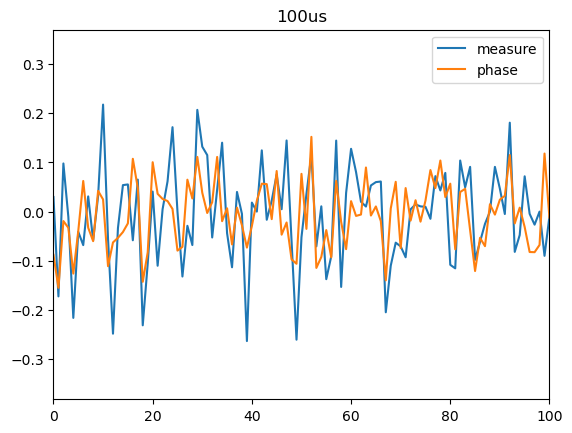

In [64]:
it3_list=np.array(it3_list)
plt.title('100us')
plt.plot(it3_list[:,0],label='measure')
plt.plot(it3_list[:,1],label='phase')
plt.xlim(0,100)
plt.legend()
plt.show()

In [66]:
def simu_phase_M5_iter2(phase_speed,sigma0=1.2,sigma1=1.2,sigma2=1.2,RAND_SEED=RAND_SEED):
    time_exposure=2 #us
    time_iter1=2 # iter*time_exposure 
    time_iter2=3 # iter*time_exposure
    #print('time exposure:',time_exposure,'iter:',time_iter1*time_exposure,time_iter2*time_exposure,time_iter3*time_exposure,time_iter4*time_exposure,'us')
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M5=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M5=np.zeros_like(phase_speed_M5)
    phase_measure_M5=np.zeros(phase_speed_M5.shape[0]) # 测量出的反馈量
    phase_measure_it1_M5=np.zeros(phase_speed_M5.shape[0])
    phase_measure_it2_M5=np.zeros(phase_speed_M5.shape[0])
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    it3_fb_list=[]
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M5[i]=np.cumsum(phase_speed_M5[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M5[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M5[i],2)
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())
        phase_measure_M5[i]=get_phase_from_count(ch1_measure,ch2_measure) 
        c0=fb_weight(phase_measure_M5[i],time_exposure=time_exposure,sigma=sigma0)
        phase_fb_M5=c0
        
        ##-- 反馈
        if i<(sig_ch1_exposure.shape[0]-1):
            phase_speed_M5[i+1,0]-=phase_fb_M5#/time_exposure # 反馈到下一个exposure
        
        ##-- 迭代反馈 one 10*time_exposure
        
        if i%time_iter1==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-1):
            phaseit1=phase_M5[i,-1]+phase_speed_M5[i+1,0]
            suffix1=get_sig_from_phase(phaseit1,1)
            suffix2=get_sig_from_phase(phaseit1,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i+1].sum()+suffix2)
            phase_measure_M5_it1=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it1_M5[i]=phase_measure_M5_it1
            c0=fb_weight(phase_measure_M5_it1,time_exposure=time_exposure*time_iter1,sigma=sigma1)
            phase_speed_M5[i+1,1]-=c0
        
        if i%time_iter2==0 and i!=0 and i<(sig_ch1_exposure.shape[0]-2) and i%time_iter1!=0:
            phaseit2=phase_M5[i,-1]+phase_speed_M5[i+1,:2].sum()
            suffix1=get_sig_from_phase(phaseit2,1)
            suffix2=get_sig_from_phase(phaseit2,2)
            ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter2:i+1].sum()+suffix1)
            ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter2:i+1].sum()+suffix2)
            phase_measure_M5_it2=get_phase_from_count(ch1_measure,ch2_measure)
            phase_measure_it2_M5[i]=phase_measure_M5_it2
            c0=fb_weight(phase_measure_M5_it2,time_exposure=time_exposure*time_iter2,sigma=sigma2)
            it3_fb_list.append([c0,phase_M5[i,-1]])
            phase_speed_M5[i+1,1]-=c0
        
        phase_offest=phase_M5[i,-1]
    phase_out_M5=np.cumsum(phase_speed_M5.reshape(-1))
    return phase_out_M5,it3_fb_list

phase_out_M5_iter2_246,it3_list=simu_phase_M5_iter2(phase_speed,0.7,0.7,0.6)
push_data(phase_out_M5_iter2_246,'phase M5 iter2')

100%|██████████| 500000/500000 [00:21<00:00, 23778.65it/s]

      phase speed     phase  phase M1  phase M4  phase M5 iter2
Mean    -0.000002 -6.359112 -0.000130  0.000372       -0.000241
Std      0.008713  2.486367  0.106453  0.086104        0.065110
Var      0.000076  6.182020  0.011332  0.007414        0.004239


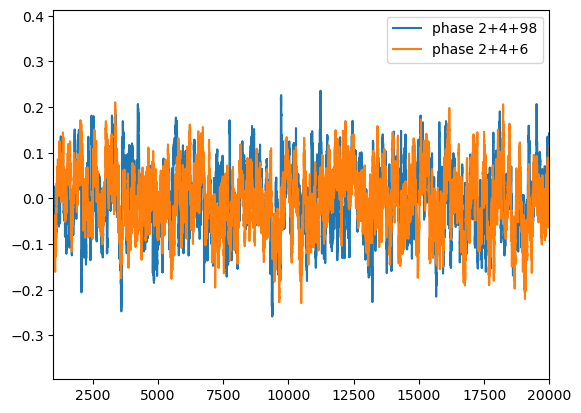

In [75]:
plt.plot(phase_out_M5_iter2,label='phase 2+4+98')
plt.plot(phase_out_M5_iter2_246,label='phase 2+4+6')
plt.xlim(1000,20000)
plt.legend()
plt.show()

# 多次模拟

In [33]:
def simu_phase(phase_speed,time_exposure,method):
    """
    method 1: instant feedback  
    method 2: average feedback  
    method 3: average feedback with iteration  
    method 4: weighted feedback  
    """
    
    time_iter1=10 # method 3 迭代参数，每隔time_iter1个exposure再进行一次测量
    
    sig_ch1_exposure=sig_ch1.reshape((-1,time_exposure))
    sig_ch2_exposure=sig_ch2.reshape((-1,time_exposure))
    phase_speed_M=np.copy(phase_speed.reshape((-1,time_exposure)))
    phase_M=np.zeros_like(phase_speed_M)
    phase_measure_M=np.zeros(phase_speed_M.shape[0]) # 测量出的反馈量
    rng=np.random.default_rng(RAND_SEED)
    phase_offest=0
    
    for i in tqdm(range(sig_ch1_exposure.shape[0])):
        phase_M[i]=np.cumsum(phase_speed_M[i])+phase_offest
        sig_ch1_exposure[i]=get_sig_from_phase(phase_M[i],1)
        sig_ch2_exposure[i]=get_sig_from_phase(phase_M[i],2)
        ###引入shot noise
        ch1_measure=rng.poisson(sig_ch1_exposure[i].sum())#+rng.poisson(1)-1  # shot noise 应该于计数有关
        ch2_measure=rng.poisson(sig_ch2_exposure[i].sum())#+rng.poisson(1)-1
        phase_measure_M[i]=get_phase_from_count(ch1_measure,ch2_measure)
        
        
        if i<(sig_ch1_exposure.shape[0]-1):
            if method==1:
                phase_speed_M[i+1,0]-=phase_measure_M[i] # 反馈到下一个exposure的起始点
            if method==2 or method==3:
                c0=phase_measure_M[i]
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1]-=phase_fb_M/time_exposure # 均匀反馈到下一个exposure时间
            if method==4:
                c0=fb_weight(phase_measure_M[i],time_exposure)
                phase_fb_M=np.sign(phase_measure_M[i])*np.abs(c0)
                phase_speed_M[i+1,0]-=phase_fb_M # 均匀反馈到下一个exposure时间

        if method==3:
            if i%time_iter1==0 and i!=0:
                ch1_measure=rng.poisson(sig_ch1_exposure[i-time_iter1:i].sum())
                ch2_measure=rng.poisson(sig_ch2_exposure[i-time_iter1:i].sum())
                phase_measure_M_it1=get_phase_from_count(ch1_measure,ch2_measure)
                c0=get_phase_from_count(ch1_measure,ch2_measure)#/100
                phase_fb_M=np.sign(phase_measure_M_it1)*np.abs(c0)
                phase_speed_M[i:i+time_iter1]-=phase_fb_M/time_exposure/time_iter1

        phase_offest=phase_M[i,-1]
    phase_out_M=np.cumsum(phase_speed_M.reshape(-1))
    return phase_out_M

out=simu_phase(phase_speed,time_exposure=20,method=4)
np.std(out)

100%|██████████| 50000/50000 [00:03<00:00, 16122.55it/s]


0.11265940212124932

In [204]:
PHASE_SEEPD=0.5/180*np.pi #rad/us
SIG_AMP=1 # 10sample/us  cps=10M
RAND_NUM=100 # 随机模拟次数
time_exposure=80
time_axis=np.arange(0,1e5,1) #1us分辨率，len=1e5us  SR=1M
sig_ch1=np.zeros_like(time_axis)
sig_ch2=np.zeros_like(time_axis)

all_phase_speed=np.zeros((RAND_NUM,time_axis.shape[0]))
all_phase=np.zeros((5,RAND_NUM,time_axis.shape[0]))

for i in range(RAND_NUM):
    rng=np.random.default_rng(i)
    phase_speed=rng.normal(0,PHASE_SEEPD,time_axis.shape)
    phase_speed[0]=0
    phase=np.cumsum(phase_speed)
    all_phase_speed[i]=phase_speed
    all_phase[0,i]=phase
    all_phase[1,i]=simu_phase(phase_speed,time_exposure=time_exposure,method=1)
    all_phase[2,i]=simu_phase(phase_speed,time_exposure=time_exposure,method=2)
    all_phase[3,i]=simu_phase(phase_speed,time_exposure=time_exposure,method=3)
    all_phase[4,i]=simu_phase(phase_speed,time_exposure=time_exposure,method=4)

  0%|          | 0/1250 [00:00<?, ?it/s]

100%|██████████| 1250/1250 [00:00<00:00, 5007.89it/s]


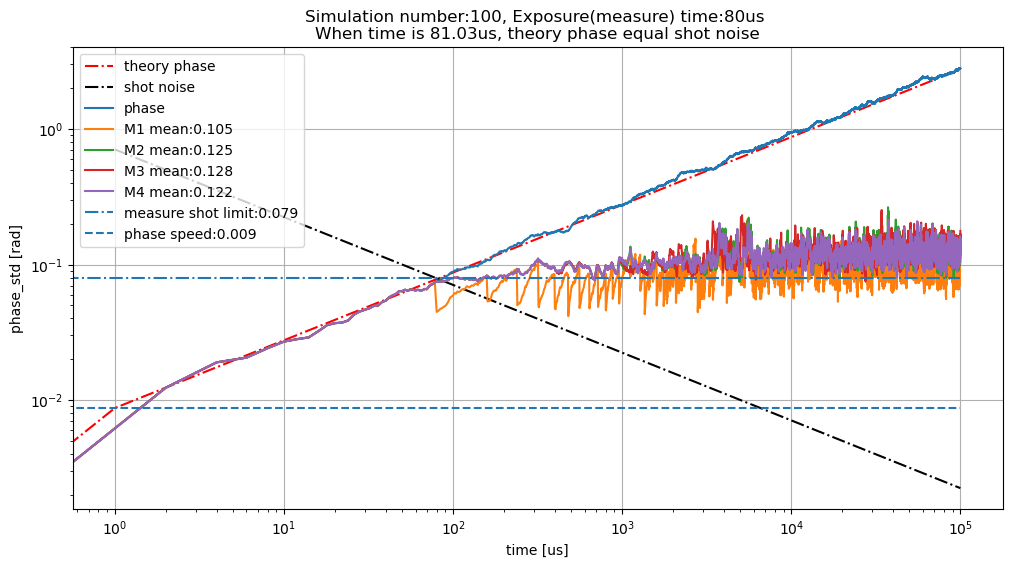

In [205]:
down_sr=2
time_axis_ds=time_axis[::down_sr] # 降采样时间轴
all_std=np.zeros((5,time_axis_ds.size))
for i in range(5):
    all_std[i]=np.std(all_phase[i,:,::down_sr],axis=0)

plt.figure(figsize=(12,6))
plt.plot(time_axis,PHASE_SEEPD*np.sqrt(time_axis),'r-.',label='theory phase')
plt.plot(time_axis[1:],1/np.sqrt(2*SIG_AMP*time_axis[1:]),'k-.',label='shot noise')
plt.plot(time_axis_ds,all_std[0],label='phase')
plt.plot(time_axis_ds,all_std[1],label='M1 mean:{:.3f}'.format(np.mean(all_std[1])))
plt.plot(time_axis_ds,all_std[2],label='M2 mean:{:.3f}'.format(np.mean(all_std[2])))
plt.plot(time_axis_ds,all_std[3],label='M3 mean:{:.3f}'.format(np.mean(all_std[3])))
plt.plot(time_axis_ds,all_std[4],label='M4 mean:{:.3f}'.format(np.mean(all_std[4])))
plt.hlines(y=1/np.sqrt(2*SIG_AMP*time_exposure),xmin=0,xmax=time_axis[-1],linestyles='-.',label='measure shot limit:{:.3f}'.format(1/np.sqrt(2*SIG_AMP*time_exposure)))
plt.hlines(y=PHASE_SEEPD,xmin=0,xmax=time_axis[-1],linestyles='--',label='phase speed:{:.3f}'.format(PHASE_SEEPD))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('time [us]')
plt.ylabel('phase_std [rad]')
text0='Simulation number:{}, Exposure(measure) time:{}us \n'.format(RAND_NUM,time_exposure)
text1='When time is {:,.2f}us, theory phase equal shot noise'.format(1/(PHASE_SEEPD*np.sqrt(2*SIG_AMP)))
plt.title(text0+text1)
plt.show()